# Attribution for recommender system model

In [49]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import scipy.sparse as sp
from torch.utils.data import DataLoader, Dataset
from captum.attr import Saliency, IntegratedGradients
import matplotlib.pyplot as plt

In [2]:
# download dataset
# url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
# !wget -q {url} -O ml-1m.zip
# !unzip -q ml-1m.zip

In [3]:
data_path = "ml-1m/ratings.dat"
movies_path = "ml-1m/movies.dat"
users_path = "ml-1m/users.dat"

data = pd.read_csv(data_path, sep="::", names=["user", "item", "rating", "timestamp"], engine="python")
movies = pd.read_csv(movies_path, sep="::", names=["item", "title", "genres"], engine="python", encoding="ISO-8859-1")
users = pd.read_csv(users_path, sep="::", names=["user", "gender", "age", "occupation", "zip"], engine="python")

In [4]:
# reindex
user_mapping = {old:new for new, old in enumerate(users["user"].unique())}
item_mapping = {old:new for new, old in enumerate(movies["item"].unique())}
data["user"] = data["user"].map(user_mapping)
data["item"] = data["item"].map(item_mapping)
movies["item"] = movies["item"].map(item_mapping)
users["user"] = users["user"].map(user_mapping)

num_users = len(user_mapping)
num_items = len(item_mapping)

In [5]:
data['rating'].values.astype(np.float32)

array([5., 3., 3., ..., 5., 4., 4.], dtype=float32)

In [6]:
# define adjacency matrix
def build_adj_matrix(data, num_users, num_items):
    rows, cols = data['user'].values, data['item'].values
    interactions = data['rating'].values.astype(np.float32)
    adj_matrix = sp.coo_matrix((interactions, (rows, cols + num_users)), 
                               shape=(num_users+num_items, num_users+num_items))
    adj_matrix = adj_matrix + adj_matrix.T # make the graph undirected
    return adj_matrix

adj_matrix = build_adj_matrix(data=data, num_users=num_users, num_items=num_items)

def normalize_adj(adj):
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return d_mat_inv_sqrt @ adj @ d_mat_inv_sqrt

adj_matrix = normalize_adj(adj_matrix)
adj_matrix = torch.FloatTensor(adj_matrix.toarray())

/var/folders/5z/8hzvmhln5p36t4tdqc9c52z40000gn/T/ipykernel_44037/1830612108.py:14: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


In [7]:
# Handle user features
gender_map = {'M':0, 'F':1}
users['gender'] = users['gender'].map(gender_map)
user_features = torch.FloatTensor(users[['gender', 'age', 'occupation']].values)

# Handle item features  
genres_set = set('|'.join(movies['genres']).split('|'))
genre_mapping = {genre: i for i, genre in enumerate(genres_set)}
movies['genres_encoded'] = movies['genres'].apply(lambda x: [genre_mapping[g] for g in x.split('|')])
movie_features = torch.zeros((num_items, len(genres_set)))
for i, row in movies.iterrows():
    for g in row['genres_encoded']:
        movie_features[row['item'], g] = 1

In [8]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, n_layers, user_feat_dim, item_feat_dim):
        super(LightGCN, self).__init__()
        # define user and item embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        # project user and item features to embedding space
        self.user_feat_fc = nn.Linear(user_feat_dim, embedding_dim) 
        self.item_feat_fc = nn.Linear(item_feat_dim, embedding_dim)
        self.n_layers = n_layers
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def forward(self, adj, user_features, item_features):
        user_feat_embed = self.user_feat_fc(user_features)
        item_feat_embed = self.item_feat_fc(item_features)
        all_embeddings = torch.cat([self.user_embedding.weight + user_feat_embed, self.item_embedding.weight + item_feat_embed], dim=0)
        embeddings = [all_embeddings]
        
        for _ in range(self.n_layers):
            all_embeddings = torch.mm(adj, all_embeddings)
            embeddings.append(all_embeddings)
        
        final_embedding = torch.mean(torch.stack(embeddings, dim=0), dim=0)
        user_final, item_final = torch.split(final_embedding, [num_users, num_items])
        return user_final, item_final

model = LightGCN(num_users, num_items, embedding_dim=64, n_layers=3, user_feat_dim=3, item_feat_dim=len(genres_set))
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss() 

def train(model, data, adj, user_features, item_features, epochs=5):
    
    model.train()
    for epoch in range(epochs):
        user_embed, item_embed = model(adj, user_features, item_features)
        loss = 0
        for user, item, rating in zip(data['user'], data['item'], data['rating']):
            user_vec = user_embed[user]
            item_vec = item_embed[item]
            score = torch.sum(user_vec * item_vec)
            loss += criterion(score, torch.tensor(float(rating)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
train(model, data, adj_matrix, user_features, movie_features, epochs=5)

Epoch 1/5, Loss: -9426617344.0000
Epoch 2/5, Loss: -10101760000.0000
Epoch 3/5, Loss: -10810675200.0000
Epoch 4/5, Loss: -11554276352.0000
Epoch 5/5, Loss: -12331766784.0000


In [14]:
torch.save(model.state_dict(), "lightgcn.pth")

In [ ]:
target_user = 0
target_item = 0

def predict_target(user_feat_batch, movie_feat_batch, target_user, target_item):
    outputs = []
    B = user_feat_batch.shape[0]
    for i in range(B):
        # 取出第 i 个样本的特征，形状为 [user_feat_dim] 和 [item_feat_dim]
        cur_user_feat = user_feat_batch[i]      # [user_feat_dim]
        cur_movie_feat = movie_feat_batch[i]    # [item_feat_dim]
        
        # 复制全局特征
        user_features_modified = user_features.clone()
        movie_features_modified = movie_features.clone()
        
        # 替换目标用户和电影的特征
        user_features_modified[target_user] = cur_user_feat
        movie_features_modified[target_item] = cur_movie_feat
        
        # 计算嵌入
        user_embed, movie_embed = model(adj_matrix, user_features_modified, movie_features_modified)
        # 计算预测评分（采用点积）
        score = torch.sum(user_embed[target_user] * movie_embed[target_item])
        outputs.append(score)
    
    # 将 list 转换为张量，形状为 [B]
    return torch.stack(outputs)

def wrapped_predict(user_feat, movie_feat, additional_forward_args=None):
    print(user_feat.shape)
    return predict_target(user_feat, movie_feat, target_user, target_item)

target_user_feat = user_features[target_user].unsqueeze(0)
target_movie_feat = movie_features[target_item].unsqueeze(0)

baseline_user_feat = torch.zeros_like(target_user_feat)
baseline_movie_feat = torch.zeros_like(target_movie_feat)

ig = IntegratedGradients(wrapped_predict)
attributions, delta = ig.attribute(
    inputs =  (target_user_feat, target_movie_feat),
    baselines = (baseline_user_feat, baseline_movie_feat),
    return_convergence_delta=True
)

attributions

torch.Size([50, 3])
torch.Size([1, 3])
torch.Size([1, 3])


(tensor([[ 47.8852, 119.1725, 546.3154]], dtype=torch.float64),
 tensor([[0.0000, 0.0000, 0.0000, 1.0187, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 1.7709, 0.0000, 2.2148, 0.0000, 0.0000]],
        dtype=torch.float64))

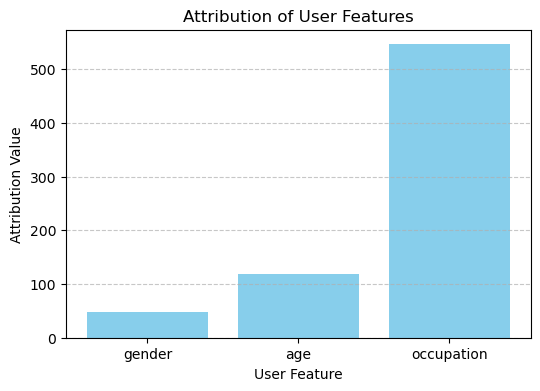

In [51]:

user_attr = attributions[0].detach().numpy()
movie_attr = attributions[1].detach().numpy()

user_feature_names = ['gender', 'age', 'occupation']

plt.figure(figsize=(6,4))
plt.bar(user_feature_names, user_attr[0], color='skyblue')
plt.xlabel("User Feature")
plt.ylabel("Attribution Value")
plt.title("Attribution of User Features")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

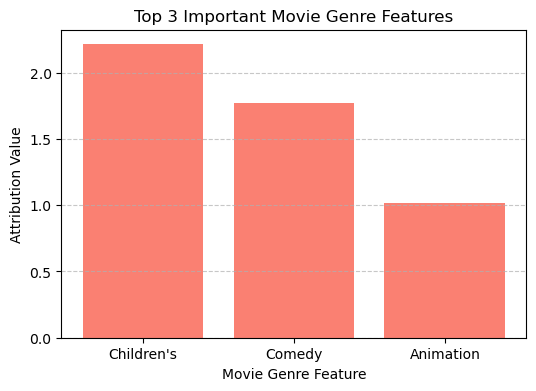

In [52]:
index_to_genre = {v: k for k, v in genre_mapping.items()}
# 构造电影特征名称列表（注意：movie_features 的每一列对应一个流派）
num_movie_features = movie_attr.shape[1]
movie_feature_names = [index_to_genre[i] for i in range(num_movie_features)]

# 取归因值的绝对值，以衡量每个特征的重要性
abs_movie_attr = np.abs(movie_attr[0])
# 选择归因值最大的三个索引（降序排列）
top3_idx = np.argsort(abs_movie_attr)[-3:][::-1]
top3_values = movie_attr[0][top3_idx]
top3_labels = [movie_feature_names[i] for i in top3_idx]

plt.figure(figsize=(6,4))
plt.bar(top3_labels, top3_values, color='salmon')
plt.xlabel("Movie Genre Feature")
plt.ylabel("Attribution Value")
plt.title("Top 3 Important Movie Genre Features")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [55]:
users

,user,gender,age,occupation,zip
0,0,1,1,10,48067
1,1,0,56,16,70072
2,2,0,25,15,55117
3,3,0,45,7,02460
4,4,0,25,20,55455
...,...,...,...,...,...
6035,6035,1,25,15,32603
6036,6036,1,45,1,76006
6037,6037,1,56,1,14706
6038,6038,1,45,0,01060
